In [1]:
from sklearn.preprocessing import LabelEncoder

# List of dog breed labels
dog_breeds = [
    "affenpinscher", "afghan_hound", "african_hunting_dog", "airedale",
    "american_staffordshire_terrier", "appenzeller", "australian_terrier", "basenji",
    "basset", "beagle", "bedlington_terrier", "bernese_mountain_dog",
    "black-and-tan_coonhound", "blenheim_spaniel", "bloodhound", "bluetick",
    "border_collie", "border_terrier", "borzoi", "boston_bull", "bouvier_des_flandres",
    "boxer", "brabancon_griffon", "briard", "brittany_spaniel", "bull_mastiff",
    "cairn", "cardigan", "chesapeake_bay_retriever", "chihuahua", "chow", "clumber",
    "cocker_spaniel", "collie", "curly-coated_retriever", "dandie_dinmont", "dhole",
    "dingo", "doberman", "english_foxhound", "english_setter", "english_springer",
    "entlebucher", "eskimo_dog", "flat-coated_retriever", "french_bulldog",
    "german_shepherd", "german_short-haired_pointer", "giant_schnauzer",
    "golden_retriever", "gordon_setter", "great_dane", "great_pyrenees",
    "greater_swiss_mountain_dog", "groenendael", "ibizan_hound", "irish_setter",
    "irish_terrier", "irish_water_spaniel", "irish_wolfhound", "italian_greyhound",
    "japanese_spaniel", "keeshond", "kelpie", "kerry_blue_terrier", "komondor",
    "kuvasz", "labrador_retriever", "lakeland_terrier", "leonberg", "lhasa",
    "malamute", "malinois", "maltese_dog", "mexican_hairless", "miniature_pinscher",
    "miniature_poodle", "miniature_schnauzer", "newfoundland", "norfolk_terrier",
    "norwegian_elkhound", "norwich_terrier", "old_english_sheepdog", "otterhound",
    "papillon", "pekinese", "pembroke", "pomeranian", "pug", "redbone",
    "rhodesian_ridgeback", "rottweiler", "saint_bernard", "saluki", "samoyed",
    "schipperke", "scotch_terrier", "scottish_deerhound", "sealyham_terrier",
    "shetland_sheepdog", "shih-tzu", "siberian_husky", "silky_terrier",
    "soft-coated_wheaten_terrier", "staffordshire_bullterrier", "standard_poodle",
    "standard_schnauzer", "sussex_spaniel", "tibetan_mastiff", "tibetan_terrier",
    "toy_poodle", "toy_terrier", "vizsla", "walker_hound", "weimaraner",
    "welsh_springer_spaniel", "west_highland_white_terrier", "whippet",
    "wire-haired_fox_terrier", "yorkshire_terrier"
]

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the labels to integers
encoded_labels = label_encoder.fit_transform(dog_breeds)

# Print the mapping of labels to integers
label_mapping = dict(zip(label_encoder.classes_, encoded_labels))



In [2]:
from os.path import samefile
!unzip sample_data/train -d dog_breed_data

Streaming output truncated to the last 5000 lines.
  inflating: dog_breed_data/train/34cbb550d54848f97181e3c041761211.jpg  
  inflating: dog_breed_data/train/34fea915be06e32d18061ee820c4a306.jpg  
  inflating: dog_breed_data/train/352893b9735e64f4b0c4faec49f88b0c.jpg  
  inflating: dog_breed_data/train/356c4208d3298e914c96d6de56328334.jpg  
  inflating: dog_breed_data/train/35cc113cc5807a081a22317ddc0e6861.jpg  
  inflating: dog_breed_data/train/35de6afba5628a315910380be1f74c57.jpg  
  inflating: dog_breed_data/train/35f3b4e4d718f399667ecc02226cc502.jpg  
  inflating: dog_breed_data/train/364e1ca0381f4ef1a78a0bc0d0e80bf9.jpg  
  inflating: dog_breed_data/train/366bd5a3738a9c21d504c8154c957e58.jpg  
  inflating: dog_breed_data/train/36df2789dc1b014cc00a978e72c65f4b.jpg  
  inflating: dog_breed_data/train/36f76ae74fb4e8bef59075574251a922.jpg  
  inflating: dog_breed_data/train/37163369901ddd0c61ae081fc9ccc53e.jpg  
  inflating: dog_breed_data/train/371c31284ee558e36c03ea3b7c3a0afa.jpg  


In [3]:
import pandas as pd
csv_file = 'sample_data/labels.csv'
data = pd.read_csv(csv_file)

# Create a mapping from image ID to breed
id_to_breed = {row['id']: row['breed'] for _, row in data.iterrows()}

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os

class DogBreedImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = data
        self.img_dir = img_dir
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.annotations['label'] = self.label_encoder.fit_transform(self.annotations['breed'])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_id = self.annotations.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")  # Adjust extension if necessary
        image = Image.open(img_path).convert("RGB")
        label = int(self.annotations.iloc[idx, 2])  # Assuming the label is in the third column

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:


# Define the standard transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the dataset
csv_file = 'labels.csv'
img_dir = 'dog_breed_data/train'
dataset = DogBreedImageDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

# Calculate the sizes of each split
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data augmentation for the training dataset
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformation for the validation dataset (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply the transformations to the datasets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Optional: Print the sizes of each dataset to verify the split
print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')


Training set size: 8688
Validation set size: 1534


In [6]:
import torch
import torch.nn as nn

class VGGNet(nn.Module):
    def __init__(self, num_classes=121):  # Adjust num_classes as needed
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # Adjust the input dimension if necessary
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),  # Adjust the output dimension
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = self.classifier(x)
        return x

# Initialize the model with the correct number of classes
model = VGGNet(num_classes=121)  # Ensure num_classes matches your dataset


In [8]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')  # Use the first available GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

# Move your model to the device
model.to(device)

Using GPU: NVIDIA A100-SXM4-40GB


VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [9]:
optimizer = torch.optim.Adagrad(params=model.parameters(), lr=0.001)

# Apply the transformations to the datasets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
loss_funtion = torch.nn.CrossEntropyLoss()

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

def accuracy(y_hat, y):
    y_pred = torch.argmax(y_hat, dim=1)
    correct = (y_pred == y).float()
    accuracy = correct.sum() / len(correct)
    return accuracy


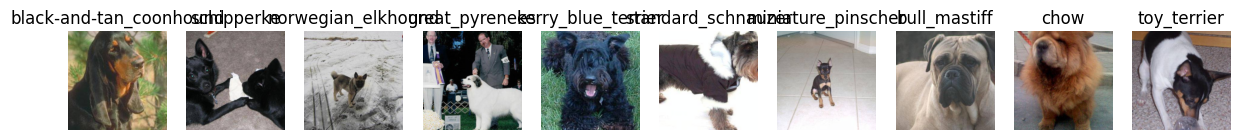

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to unnormalize the images
def imshow(img, mean, std):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor format (C, H, W) to (H, W, C)
    img = img * std + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip to be in the range [0, 1] for plotting
    plt.imshow(img)

# Define mean and std for unnormalization (same as used in transforms.Normalize)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Plot images from DataLoader
plt.figure(figsize=(15, 15))
for i, (inputs, labels) in enumerate(train_loader):
    if i == 10:  # Display only 10 images
        break
    plt.subplot(1, 10, i + 1)
    imshow(inputs[0], mean, std)
    label = label_encoder.inverse_transform([labels[0].item()])[0]
    plt.title(label)
    plt.axis('off')
plt.show()


In [13]:
num_epochs = 30
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    total_samples = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = loss_funtion(outputs, labels)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss.backward()
        optimizer.step()

        acc = accuracy(outputs, labels)

        # Accumulate loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_accuracy += acc.item() * inputs.size(0)
        total_samples += inputs.size(0)
    avg_loss = running_loss / total_samples
    avg_acc = running_accuracy / total_samples
    train_losses.append(avg_loss)
    train_accuracies.append(avg_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}, Accuracy: {avg_acc :.4f}')

Epoch [1/30] Loss: 3.7461, Accuracy: 0.1264
Epoch [2/30] Loss: 3.6031, Accuracy: 0.1454
Epoch [3/30] Loss: 3.4709, Accuracy: 0.1739
Epoch [4/30] Loss: 3.2623, Accuracy: 0.2116
Epoch [5/30] Loss: 3.0297, Accuracy: 0.2502
Epoch [6/30] Loss: 2.7458, Accuracy: 0.3187
Epoch [7/30] Loss: 2.4222, Accuracy: 0.3863
Epoch [8/30] Loss: 2.0674, Accuracy: 0.4640
Epoch [9/30] Loss: 1.7037, Accuracy: 0.5371
Epoch [10/30] Loss: 1.3633, Accuracy: 0.6248
Epoch [11/30] Loss: 1.0866, Accuracy: 0.6985
Epoch [12/30] Loss: 0.8285, Accuracy: 0.7667
Epoch [13/30] Loss: 0.6776, Accuracy: 0.8130
Epoch [14/30] Loss: 0.5110, Accuracy: 0.8547
Epoch [15/30] Loss: 0.4062, Accuracy: 0.8809
Epoch [16/30] Loss: 0.3471, Accuracy: 0.8971
Epoch [17/30] Loss: 0.2823, Accuracy: 0.9163
Epoch [18/30] Loss: 0.2595, Accuracy: 0.9294
Epoch [19/30] Loss: 0.2141, Accuracy: 0.9406
Epoch [20/30] Loss: 0.1966, Accuracy: 0.9439
Epoch [21/30] Loss: 0.1667, Accuracy: 0.9563
Epoch [22/30] Loss: 0.1439, Accuracy: 0.9595
Epoch [23/30] Loss:

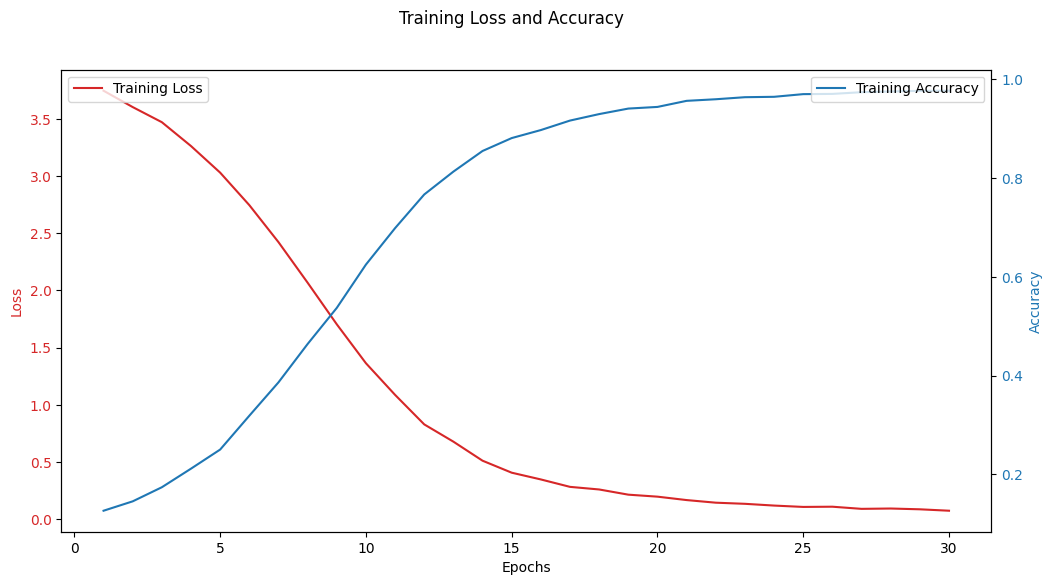

In [15]:


# Plotting the training loss and accuracy on the same graph with different y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot training loss
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, num_epochs + 1), train_losses, color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot accuracy
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(range(1, num_epochs + 1), train_accuracies, color=color, label='Training Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
fig.suptitle('Training Loss and Accuracy')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.show()
